In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random

In [2]:
# --------------------------
# PATHS
# --------------------------
train_dir = "D:/Cherry_Dataset/Cherry/train"
test_dir  = "D:/Cherry_Dataset/Cherry/test"

In [3]:
# --------------------------
# HYPERPARAMETERS
# --------------------------
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-4

In [4]:
# --------------------------
# DATA AUGMENTATION + NORMALIZATION
# --------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.10,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [5]:
# --------------------------
# TRAIN / VAL GENERATOR
# --------------------------
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # 5 sınıf olduğundan categorical
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 3198 images belonging to 5 classes.
Found 798 images belonging to 5 classes.


In [6]:
# --------------------------
# TEST GENERATOR
# --------------------------
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 999 images belonging to 5 classes.


In [7]:
# --------------------------
# BASE MODEL
# --------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False


In [8]:
# --------------------------
# CUSTOM HEAD
# --------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# --------------------------
# CALLBACKS
# --------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint("best_cherry_model.keras", monitor='val_loss', save_best_only=True)
]


In [10]:
# --------------------------
# TRAIN MODEL
# --------------------------
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5660 - loss: 1.1766 - val_accuracy: 0.7243 - val_loss: 0.7494 - learning_rate: 1.0000e-04
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 936ms/step - accuracy: 0.7861 - loss: 0.5996 - val_accuracy: 0.8308 - val_loss: 0.5437 - learning_rate: 1.0000e-04
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 960ms/step - accuracy: 0.8483 - loss: 0.4372 - val_accuracy: 0.8484 - val_loss: 0.4337 - learning_rate: 1.0000e-04
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 98s 980ms/step - accuracy: 0.8705 - loss: 0.3593 - val_accuracy: 0.8772 - val_loss: 0.3892 - learning_rate: 1.0000e-04
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 914ms/step - accuracy: 0.8840 - loss: 0.3158 - val_accuracy: 0.8596 - val_loss: 0.3814 - learning_rate: 1.0000e-04
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 900ms/step - accuracy: 0.8974 - loss: 0.2768 - val_accuracy: 0.8622 - val_loss: 0.3876 - learning_rate: 1.0000e-04
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 921m

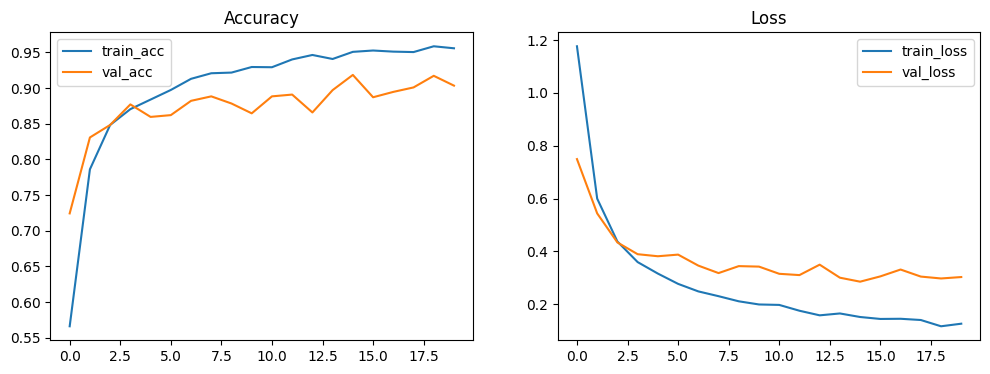

In [11]:
# --------------------------
# PLOT ACC & LOSS
# --------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.show()


In [12]:
# --------------------------
# EVALUATE
# --------------------------
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)



32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.9640 - loss: 0.1309
Test Accuracy: 0.9639639854431152


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step


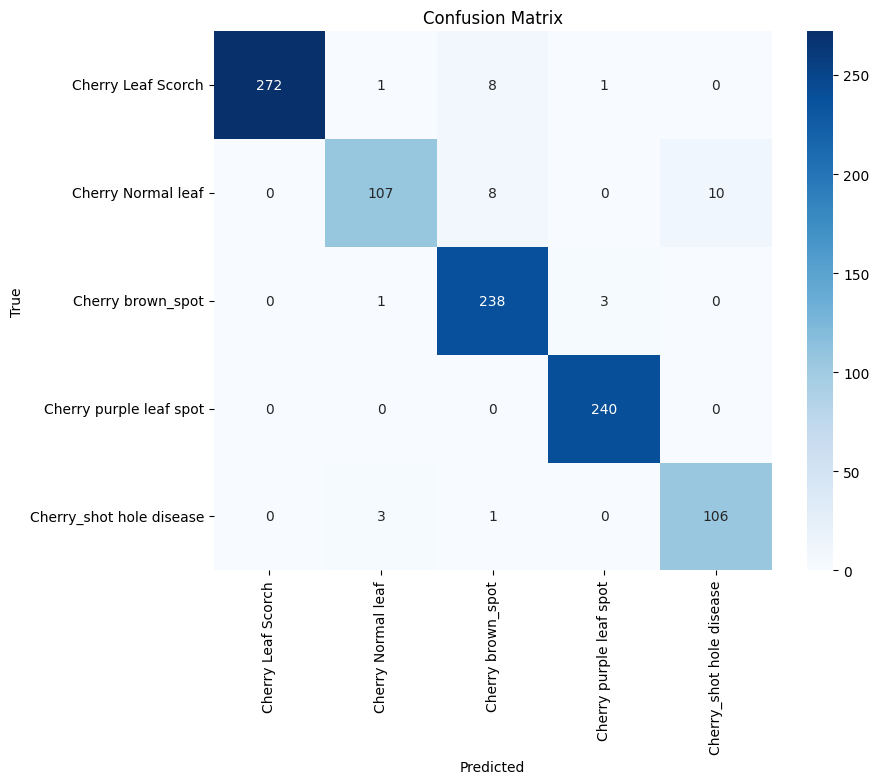

In [13]:
# --------------------------
# CONFUSION MATRIX
# --------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = test_generator.classes
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(),
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


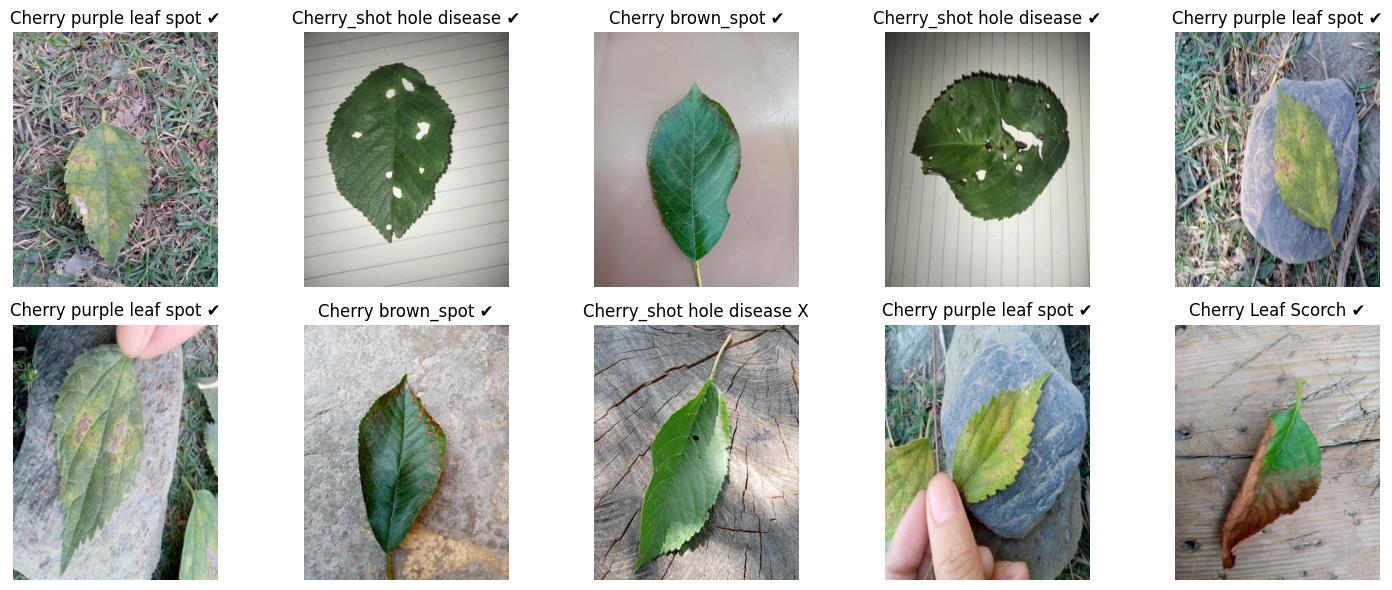

In [20]:
# --------------------------
# RANDOM 10 TEST SAMPLES
# --------------------------

class_names = list(test_generator.class_indices.keys())

test_class_dirs = [os.path.join(test_dir, cls) for cls in class_names]

test_files = []
test_labels = []

for idx, c in enumerate(test_class_dirs):
    for f in os.listdir(c):
        test_files.append(os.path.join(c, f))
        test_labels.append(idx)

indices = random.sample(range(len(test_files)), 10)
sample_files = [test_files[i] for i in indices]
sample_labels = [test_labels[i] for i in indices]

plt.figure(figsize=(15,6))

for i, (file, true_label) in enumerate(zip(sample_files, sample_labels)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224,224)) / 255.0
    img_input = np.expand_dims(img_resized, axis=0)
    
    pred = model.predict(img_input)[0]
    pred_label = np.argmax(pred)
    
    symbol = "✔️" if pred_label == true_label else "X"
    
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(f"{class_names[pred_label]} {symbol}")
    plt.axis('off')

plt.tight_layout()
plt.show()